# Model Training and Validation 

- Takes train and val scan IDs (i.e. individuals) from cross-val generator
- Uses train generator to sample slices from case and control train samples. Performs data augmentations (optional)
- Trains the model for a single hyper-param config. Reports performance on validation slices. 

### Imports

In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import sys
import os
import pickle

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.training_utils import *

### Paths

In [2]:
project_dir = '../' # local or Dropbox location for dicoms
data_dir = project_dir + 'data/'

metadata_file = data_dir + 'CT_metatdata.pkl' # scan IDs, slice paths, lung partition, and demographic info
CV_dict_file = data_dir + 'CV_indices.pkl' # k-fold train-test indices 


### Configs

In [3]:
RANDOM_SEED = 153
n_folds = 2

case_label = 1
control_label = 0

slice_shape = (64,64)
num_classes = 2

### Load data

In [4]:
# Dummy data
metadata_df=pd.DataFrame()
n_scans = 100
n_parts = 3
metadata_df['CT_id'] = np.repeat(range(n_scans),n_parts)
metadata_df['DX'] = list(np.repeat(np.zeros(n_scans//2),n_parts)) + list(np.repeat(np.ones(n_scans//2),n_parts))
metadata_df['partition_id'] = np.tile(range(n_parts),n_scans)
metadata_df['slice_id']= metadata_df['CT_id'].astype(str)+ '_' + metadata_df['partition_id'].astype(str)
metadata_df['slice_label'] = np.mod(metadata_df['partition_id'],2) #ideal case: DX, partition_case: centre vs [top or bottom]

# Real data
# metadata_df  = pd.read_pickle(metadata_file)

# Scan level info
scan_df = metadata_df[['CT_id','DX']].drop_duplicates()

n_scans = len(metadata_df['CT_id'].unique())
n_slices = len(np.hstack(metadata_df['slice_id'].values))
n_partitions = len(metadata_df['partition_id'].unique())
n_scan_cases = len(scan_df[metadata_df['DX']==case_label])
n_scan_controls = len(scan_df[metadata_df['DX']==control_label])
n_slice_cases = len(metadata_df[metadata_df['slice_label']==case_label])
n_slice_controls = len(metadata_df[metadata_df['slice_label']==control_label])

print('Number of total scans: {}, slices: {}, partitions: {}\nscan_cases: {}, scan_controls: {}\nslice_cases: {}, slice_controls: {}'.format(n_scans,n_slices,n_partitions,n_scan_cases,n_scan_controls,n_slice_cases,n_slice_controls))

metadata_df.head()

Number of total scans: 100, slices: 300, partitions: 3
scan_cases: 50, scan_controls: 50
slice_cases: 100, slice_controls: 200


,CT_id,DX,partition_id,slice_id,slice_label
0,0,0.0,0,0_0,0
1,0,0.0,1,0_1,1
2,0,0.0,2,0_2,0
3,1,0.0,0,1_0,0
4,1,0.0,1,1_1,1


### Cross-validation indices
- Shuffle happens at the scan (individual) level and not at the slice level. 

In [5]:
generate_CV_folds = True
save_CV = True

X = scan_df['CT_id'].values
y = scan_df['DX'].values

if not generate_CV_folds:
    print('Loading CV indices from: {}'.format(CV_dict_file))
    CV_index_dict = pickle.load( open(CV_dict_file, "rb") )
    
else:
    print('Generating CV folds to divide scans IDs balanced by groups...')
    
    skf = StratifiedKFold(n_splits=n_folds, random_state=RANDOM_SEED, shuffle=True)
    skf.get_n_splits(X, y)
    
    CV_index_dict = {}
    cv = 0
    for train_index, test_index in skf.split(X, y):
        # print("TRAIN:", train_index, "TEST:", test_index)
        slice_labels_train = metadata_df[metadata_df['CT_id'].isin(train_index)]['slice_label'].value_counts()
        slice_labels_test = metadata_df[metadata_df['CT_id'].isin(test_index)]['slice_label'].value_counts()
        print('\nSlice label distribution for fold: {}\ntrain: {}, test: {}'.format(cv, dict(slice_labels_train), dict(slice_labels_test)))
        CV_index_dict[cv] = {'train':train_index, 'test':test_index}
        cv = cv + 1

    if save_CV:
        pickle.dump(CV_index_dict, open( CV_dict_file, "wb" ) )
        print('\nSaving CV indices to: {}'.format(CV_dict_file))

Generating CV folds to divide scans IDs balanced by groups...

Slice label distribution for fold: 0
train: {0: 100, 1: 50}, test: {0: 100, 1: 50}

Slice label distribution for fold: 1
train: {0: 100, 1: 50}, test: {0: 100, 1: 50}

Saving CV indices to: ../data/CV_indices.pkl


### Generate train and test slice samples for a CV fold 

In [6]:
cv_idx = 0 
val_subset_frac = 0.2 #this is a subset within the train samples that is used to validate and select hyper-params

train_plus_val_index = CV_index_dict[cv_idx]['train']
train_sampx = int((1-val_subset_frac)*len(train_plus_val_index))
train_index = train_plus_val_index[:train_sampx]
val_index = train_plus_val_index[train_sampx:]

test_index = CV_index_dict[cv_idx]['test']

print('Number of scans\ntrain: {}, val: {}, test: {}'.format(len(train_index),len(val_index),len(test_index)))

# CT IDs
X_train, X_val, X_test = X[train_index], X[val_index], X[test_index]
y_train, y_val, y_test = y[train_index], y[val_index], y[test_index]

## Train generator
data_subset = 'train'
train_gen = batch_generator(X_train, metadata_df, data_subset, slice_shape, num_classes)

batch = next(train_gen)
print('number of slice samples in a {} batch: {}'.format(data_subset, len(batch[1])))
train_slice_img = batch[0][0]
train_slice_label = batch[1][0]

## Val generator
data_subset = 'val'
val_gen = batch_generator(X_val, metadata_df, data_subset, slice_shape, num_classes)

batch = next(val_gen)
print('number of slice samples in a {} batch: {}'.format(data_subset, len(batch[1])))
val_slice_img = batch[0][0]
val_slice_label = batch[1][0]

## Test generator
data_subset = 'test'
test_gen = batch_generator(X_test, metadata_df, data_subset, slice_shape, num_classes)

batch = next(test_gen)
print('number of slice samples in a {} batch: {}'.format(data_subset, len(batch[1])))
test_slice_img = batch[0][0]
test_slice_label = batch[1][0]


Number of scans
train: 40, val: 10, test: 50
number of slice samples in a train batch: 120
number of slice samples in a val batch: 30
number of slice samples in a test batch: 150


### View train, val, and test slice samples

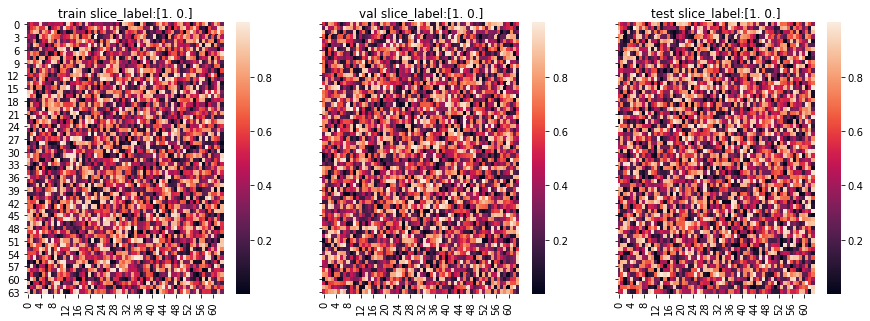

In [7]:
slice_sample_dict = {'train':(train_slice_img,train_slice_label),'val':(val_slice_img,val_slice_label),'test':(test_slice_img,test_slice_label)}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5),sharex=True,sharey=True) 
a = 0
for subset,(img,label) in slice_sample_dict.items():
    ax = axes[a]
    g = sns.heatmap(np.squeeze(img), ax=ax)
    ax.title.set_text(subset + ' slice_label:' + str(label))
    a += 1


### Model config

In [8]:
# Model / data parameters
input_shape = (slice_shape[0], slice_shape[1], 1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0         
____

### Train model

In [9]:
batch_size = 1
epochs = 5
steps_per_epoch = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(train_gen, validation_data=val_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=1)

Epoch 1/5
5/5 [==============================] - 2s 434ms/step - loss: 0.7110 - acc: 0.6217 - val_loss: 0.6497 - val_acc: 0.6667
Epoch 2/5
5/5 [==============================] - 1s 193ms/step - loss: 0.6787 - acc: 0.5867 - val_loss: 0.6389 - val_acc: 0.6667
Epoch 3/5
5/5 [==============================] - 1s 193ms/step - loss: 0.6495 - acc: 0.6550 - val_loss: 0.6446 - val_acc: 0.6667
Epoch 4/5
5/5 [==============================] - 1s 196ms/step - loss: 0.6504 - acc: 0.6667 - val_loss: 0.6343 - val_acc: 0.6667
Epoch 5/5
5/5 [==============================] - 1s 193ms/step - loss: 0.6478 - acc: 0.6633 - val_loss: 0.6398 - val_acc: 0.6667


### Evaluate Model (at the moment on dummy data)

In [10]:
score = model.evaluate(test_gen, verbose=0, steps=10)
print("Test loss: {:3.2f}".format(score[0]))
print("Test accuracy: {:3.2f}".format(score[1]))

Test loss: 0.64
Test accuracy: 0.67
